In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

# display results to 3 decimal points, not in scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
raw_user_data = pd.read_table(
    'C:/Users/alex_/Desktop/Recommender System/lastfm-dataset-360K/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv',
                          header = None, nrows = 2e7,
                          names = ['users', 'musicbrainz-artist-id', 'artist-name', 'plays'],
                          usecols = ['users', 'artist-name', 'plays'])
raw_user_profiles = pd.read_table(
    'C:/Users/alex_/Desktop/Recommender System/lastfm-dataset-360K/lastfm-dataset-360K/usersha1-profile.tsv',
                          header = None,
                          names = ['users', 'gender', 'age', 'country', 'signup'],
                          usecols = ['users', 'country'])

In [10]:
print(raw_user_data.shape)
raw_user_data.head()

(17535655, 3)


,users,artist-name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


In [190]:
print(raw_user_profiles.shape)
raw_user_profiles.head()

(359347, 2)


,users,country
0,00000c289a1829a808ac09c00daf10bc3c4e223b,Germany
1,00001411dc427966b17297bf4d69e7e193135d89,Canada
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,Germany
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,Mexico
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,United States


## Exploratory data analysis


In [6]:
raw_user_data['artist-name'].isnull().sum()

204

In [7]:
if raw_user_data['artist-name'].isnull().sum() > 0:
    user_data = raw_user_data.dropna(axis = 0, subset = ['artist-name'])

In [7]:
user_data.shape  #17535655-204

(17535451, 3)

In [8]:
artist_plays = (user_data.groupby(by = ['artist-name'])['plays'].sum().
     reset_index().                                               #give indexes to the dataframe
     rename(columns = {'plays': 'total_artist_plays'})
    )
#artist_plays

In [27]:
artist_plays.head()

,artist-name,total_artist_plays
0,04)],6
1,2,1606
2,58725ab=>,23
3,80lİ yillarin tÜrkÇe sÖzlÜ aŞk Şarkilari,70
4,amy winehouse,23


In [9]:
user_data_with_artist_plays = user_data.merge(artist_plays, left_on = 'artist-name', right_on = 'artist-name', how = 'left')

user_data_with_artist_plays.head()

,users,artist-name,plays,total_artist_plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137,25651
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,3704875
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897,180391
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717,410725
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706,90498


### Picking a threshold for popular artists


In [20]:
import matplotlib.pyplot as plt  
import seaborn as sns  
%matplotlib inline


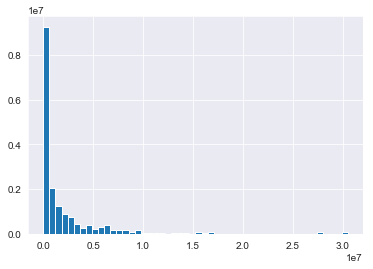

In [21]:
user_data_with_artist_plays['total_artist_plays'].hist(bins=50) 

In [30]:
artist_plays['total_artist_plays'].describe()

count     292363.000
mean       12907.022
std       185981.631
min            1.000
25%           53.000
50%          208.000
75%         1048.000
max     30466827.000
Name: total_artist_plays, dtype: float64

In [31]:
artist_plays['total_artist_plays'].quantile(np.arange(.9, 1, .01))

0.900     6137.800
0.910     7409.420
0.920     9102.040
0.930    11474.660
0.940    14898.000
0.950    19964.500
0.960    28420.120
0.970    43541.420
0.980    79403.560
0.990   198483.660
Name: total_artist_plays, dtype: float64

In [23]:
popularity_threshold = 40000
user_data_popular_artists = user_data_with_artist_plays.query('total_artist_plays >= @popularity_threshold')
print(user_data_popular_artists.shape)
user_data_popular_artists.head()

(14159003, 4)


,users,artist-name,plays,total_artist_plays
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,3704875
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897,180391
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717,410725
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706,90498
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691,13547741


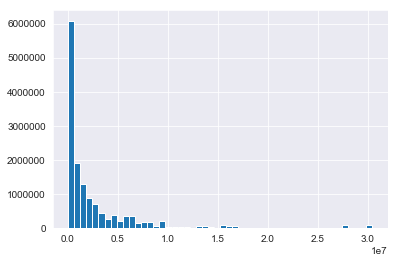

In [24]:
user_data_popular_artists['total_artist_plays'].hist(bins=50) 

In [53]:
combined = user_data_popular_artists.merge(user_profiles, left_on = 'users', right_on = 'users', how = 'left')


In [58]:
usa_data = combined.query('country == \'United States\' ')

In [59]:
usa_data.head()

,users,artist-name,plays,total_artist_plays,country
156,00007a47085b9aab8af55f52ec8846ac479ac4fe,devendra banhart,456,2366807,United States
157,00007a47085b9aab8af55f52ec8846ac479ac4fe,boards of canada,407,6115545,United States
158,00007a47085b9aab8af55f52ec8846ac479ac4fe,cocorosie,386,2194862,United States
159,00007a47085b9aab8af55f52ec8846ac479ac4fe,aphex twin,213,4248296,United States
160,00007a47085b9aab8af55f52ec8846ac479ac4fe,animal collective,203,3495537,United States


In [61]:
if not usa_data[usa_data.duplicated(['users', 'artist-name'])].empty:
    initial_rows = usa_data.shape[0]
    
    print ('Initial dataframe shape {0}'.format(usa_data.shape))
    usa_data = usa_data.drop_duplicates(['users', 'artist-name'])
    current_rows = usa_data.shape[0]
    print ('New dataframe shape {0}'.format(usa_data.shape))
    print ('Removed {0} rows'.format(initial_rows - current_rows))

Initial dataframe shape (2788019, 5)
New dataframe shape (2788013, 5)
Removed 6 rows


### Implemeting the Nearest Neighbor Model


In [62]:
wide_artist_data = usa_data.pivot(index = 'artist-name', columns = 'users', values = 'plays').fillna(0)
wide_artist_data_sparse = csr_matrix(wide_artist_data.values)

In [65]:
wide_artist_data.head()

users,00007a47085b9aab8af55f52ec8846ac479ac4fe,0001a57568309b287363e72dc682e9a170ba6dc2,00024b5b85c40f990c28644d53257819980bf6bb,0002dd2154072434d26e5409faa591bfb260a01e,00032c7933e0eb05f2258f1147ef81a90f2d4d6c,00041cbfdd019b5431f926133266cc4ba38219bb,000429493d9716b66b02180d208d09b5b89fbe64,000701c3c006b091990162635b36b008c504c6a7,000752c87a61bc4247f5219b4769c347c0062c8a,0008538a0f505f72fdd66af3c4c71aef8d3bdea4,...,fff58a5c95280b7af63f9c552f9159b58ae5efa3,fff694cf332ed701dccbf17f1d9595ba8ad69f22,fff69e7cb53568c732909648527a778c31befec8,fff820efe22db6c868515436de82af39e013b910,fff89b6b5332f0f38996f11c88f908a3924926fe,fff9dc65e7f2763a7e8bce8d99cc1491c2ae4c6f,fffa9294e858a7c863b5ad363c748c2330d9bd45,fffa9d62caff0f038c7a35db70f109b1bba04a1d,fffaf6f9a1a3ad8bd0dff7b48b2eb9eef030fdee,fffe8c7f952d9b960a56ed4dcb40a415d924b224
artist-name,,,,,,,,,,,,,,,,,,,,,
!!!,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
#####,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
(+44),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
(hed) planet earth,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
*nsync,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [64]:
wide_artist_data_sparse

<9127x66913 sparse matrix of type '<class 'numpy.float64'>'
	with 2788013 stored elements in Compressed Sparse Row format>

#### Fitting the model

In [67]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(wide_artist_data_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [169]:
query_index = np.random.choice(wide_artist_data.shape[0])
print (query_index)
query_index=6398  #1721-coldplay
distances, indices = model_knn.kneighbors(wide_artist_data.iloc[query_index, :].to_numpy().reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print ('Recommendations for {0}:\n'.format(wide_artist_data.index[query_index]))
    else:
        print ('{0}: {1}, with distance of {2}:'.format(i, 
                                                        wide_artist_data.index[indices[0][i]], 
                                                        distances[0][i]))

6142
Recommendations for red hot chili peppers:

1: john frusciante, with distance of 0.6608648276527587:
2: incubus, with distance of 0.7361444139503781:
3: rage against the machine, with distance of 0.7803890133432729:
4: audioslave, with distance of 0.7987096084643394:
5: sublime, with distance of 0.8094301405164908:


### Binary Play Count

In [172]:
wide_artist_data_zero_one = wide_artist_data.apply(np.sign)
#The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0. nan is returned for nan inputs.
wide_artist_data_zero_one_sparse = csr_matrix(wide_artist_data_zero_one.values)


In [173]:
model_nn_binary = NearestNeighbors(metric='cosine', algorithm='brute')
model_nn_binary.fit(wide_artist_data_zero_one_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [176]:

query_index = np.random.choice(wide_artist_data_zero_one.shape[0])
query_index=6398
#print query_index
distances, indices = model_nn_binary.kneighbors(
                        wide_artist_data_zero_one.iloc[query_index, :].to_numpy().reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print ('Recommendations with binary play data for {0}:\n'.format(wide_artist_data_zero_one.index[query_index]))
    else:
        print ('{0}: {1}, with distance of {2}:'.format(i, 
                                                       wide_artist_data_zero_one.index[indices[0][i]], 
                                                       distances[0][i]))

Recommendations with binary play data for red hot chili peppers:

1: incubus, with distance of 0.6866329121659049:
2: the beatles, with distance of 0.6938567428877458:
3: sublime, with distance of 0.705400375259746:
4: foo fighters, with distance of 0.7115568685895525:
5: coldplay, with distance of 0.7166914223483436:


In [180]:
from fuzzywuzzy import fuzz 
import string

In [184]:
def print_artist_recommendations(query_artist, artist_plays_matrix, knn_model, k):
    """
    Inputs:
    query_artist: query artist name
    artist_plays_matrix: artist play count dataframe (not the sparse one, the pandas dataframe)
    knn_model: our previously fitted sklearn knn model
    k: the number of nearest neighbors.
    
    Prints: Artist recommendations for the query artist
    Returns: None
    """
    query_index = None
    ratio_tuples = []
    
    for i in artist_plays_matrix.index:
        ratio = fuzz.ratio(i.lower(), query_artist.lower())
        if ratio >= 75:
            current_query_index = artist_plays_matrix.index.tolist().index(i)
            ratio_tuples.append((i, ratio, current_query_index))
    
    print('Possible matches: {0}\n'.format([(x[0], x[1]) for x in ratio_tuples]))
    
    try:
        query_index = max(ratio_tuples, key = lambda x: x[1])[2] # get the index of the best artist match in the data
    except:
        print('Your artist didn\'t match any artists in the data. Try again')
        return None
    
    distances, indices = knn_model.kneighbors(artist_plays_matrix.iloc[query_index, :].to_numpy().reshape(1, -1), 
                                              n_neighbors = k + 1)

    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for {0}:\n'.format(artist_plays_matrix.index[query_index]))
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, 
                                                           artist_plays_matrix.index[indices.flatten()[i]], 
                                                           distances.flatten()[i]))

    return None

In [185]:
print_artist_recommendations('red hot chili peppers', wide_artist_data_zero_one, model_nn_binary, k = 10)

Possible matches: [('red hot chili peppers', 100)]

Recommendations for red hot chili peppers:

1: incubus, with distance of 0.6866329121659049:
2: the beatles, with distance of 0.6938567428877458:
3: sublime, with distance of 0.705400375259746:
4: foo fighters, with distance of 0.7115568685895525:
5: coldplay, with distance of 0.7166914223483436:
6: led zeppelin, with distance of 0.7224887876238412:
7: nirvana, with distance of 0.7249439831689736:
8: green day, with distance of 0.7346038131182646:
9: radiohead, with distance of 0.7373723028024795:
10: rage against the machine, with distance of 0.7401364919569786:


In [189]:
print_artist_recommendations('daddy yankee', wide_artist_data_zero_one, model_nn_binary, k = 10)

Possible matches: [('daddy yankee', 100)]

Recommendations for daddy yankee:

1: don omar, with distance of 0.6165208225306998:
2: tito el bambino, with distance of 0.6941478544707503:
3: aventura, with distance of 0.7354114842916597:
4: calle 13, with distance of 0.7667567569140259:
5: wisin & yandel, with distance of 0.778116298889297:
6: arcangel, with distance of 0.7935301862036622:
7: pitbull, with distance of 0.7960541464001651:
8: camila, with distance of 0.8650264603185392:
9: rbd, with distance of 0.8674801485751004:
10: maná, with distance of 0.8720469612852861:
